In [1]:
import os, sys 
from functools import partial

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
import pickle as pkl
import lightgbm as lgb

print(sys.version)
for i in [pd, mpl, sns, sklearn, scipy, lgb]:
    print(i.__name__, i.__version__)

3.12.3 (main, May  7 2024, 08:28:12) [GCC 9.4.0]
pandas 2.2.2
matplotlib 3.8.4
seaborn 0.13.2
sklearn 1.4.2
scipy 1.13.0
lightgbm 4.3.0


In [2]:
from sklearn.metrics import r2_score

In [3]:
from IPython.display import Image
def cache_fig(img_name, img_func, nrow, ncol, figsize, redraw=False):
    img_file_name = os.path.join(img_path, img_name + '.png')
    if not os.path.exists(img_file_name) or redraw:
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
        if nrow * ncol > 1:
            img_func(axes.ravel())
        else:
            img_func(axes)
        plt.tight_layout()
        plt.savefig(img_file_name)
        plt.show()
    else:
        display(Image(filename=img_file_name))

def cache_result(result_name, result_func, rerun=False):
    result_file_name = os.path.join(result_path, result_name + '.pkl')
    if not os.path.exists(result_file_name) or rerun:
        result = result_func()
        if result is None:
            return
        with open(result_file_name, 'wb') as f:
            pkl.dump(result, f)
    else:
        with open(result_file_name, 'rb') as f:
            result = pkl.load(f)
    return result

def diff_graph(axes, s_prd, s_res):
    sns.lineplot(
        pd.concat([(s_prd * 200).astype('int') / 200, df_train[target]], axis=1), x=s_prd.name, y='FloodProbability', ax=axes[0]
    )
    sns.lineplot(
        pd.concat([(s_prd * 200).astype('int') / 200, s_res], axis=1), x=s_prd.name, y=s_res.name, ax=axes[1]
    )
    axes[1].axhline(0)
    sns.scatterplot(
        pd.concat([s_prd, s_res], axis=1), x=s_prd.name, y=s_res.name, ax=axes[2], s=10, alpha=0.01
    )

In [4]:
data_path = 'data'
img_path = 'img'
result_path = 'result'
if not os.path.isdir(img_path):
    os.mkdir(img_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('org', data_path, 'flood.csv'),
        ('test', data_path, 'test.csv'),
        ('type', data_path, 'type.pkl'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

# 데이터 불러오기 및 변수 종류 설정

In [5]:
df_var = pd.read_pickle(files['var_pkl'])
df_train = pd.read_pickle(files['train_pkl'])
df_org = pd.read_pickle(files['org_pkl'])
df_test = pd.read_pickle(files['test_pkl'])

In [6]:
target = 'FloodProbability'
X_num_org = df_var.loc[(~df_var.index.isin(['id', target])) & (df_var['src'] == 'org')].index.tolist()
X_sort = df_var.loc[df_var['src'] == 'sort'].index.tolist()

In [7]:
X_all = df_var.loc[~df_var.index.isin(['id', target])].index.tolist()

## 원본 연속형 변수의 기술통계량

In [8]:
df_train[X_num_org].describe()

,AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,DeterioratingInfrastructure,DrainageSystems,Encroachments,InadequatePlanning,IneffectiveDisasterPreparedness,Landslides,MonsoonIntensity,PoliticalFactors,PopulationScore,RiverManagement,Siltation,TopographyDrainage,Urbanization,Watersheds,WetlandLoss
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,4.942619e+00,4.934093e+00,4.953999e+00,4.955878e+00,4.942240e+00,4.925907e+00,4.946893e+00,4.949230e+00,4.940587e+00,4.945239e+00,4.931376e+00,4.921450e+00,4.939004e+00,4.927520e+00,4.955322e+00,4.927791e+00,4.926671e+00,4.942517e+00,4.929032e+00,4.950859e+00
std,2.068545e+00,2.057742e+00,2.088899e+00,2.083063e+00,2.051689e+00,2.064813e+00,2.072333e+00,2.083324e+00,2.081123e+00,2.078141e+00,2.078287e+00,2.056387e+00,2.090350e+00,2.074176e+00,2.072186e+00,2.065992e+00,2.093879e+00,2.083391e+00,2.082395e+00,2.068696e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00
50%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
75%,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00
max,1.600000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.800000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.800000e+01,1.600000e+01,1.600000e+01,1.800000e+01,1.700000e+01,1.600000e+01,1.900000e+01


X_all 은 모두 int8 형식으로 구성되어 있습니다. 분포를 보아 수치형인지, 범주형인지 살펴 봅니다. 

X_all은 모두 비슷한 범위를 가지고 있습니다.

## 변수들의 분포

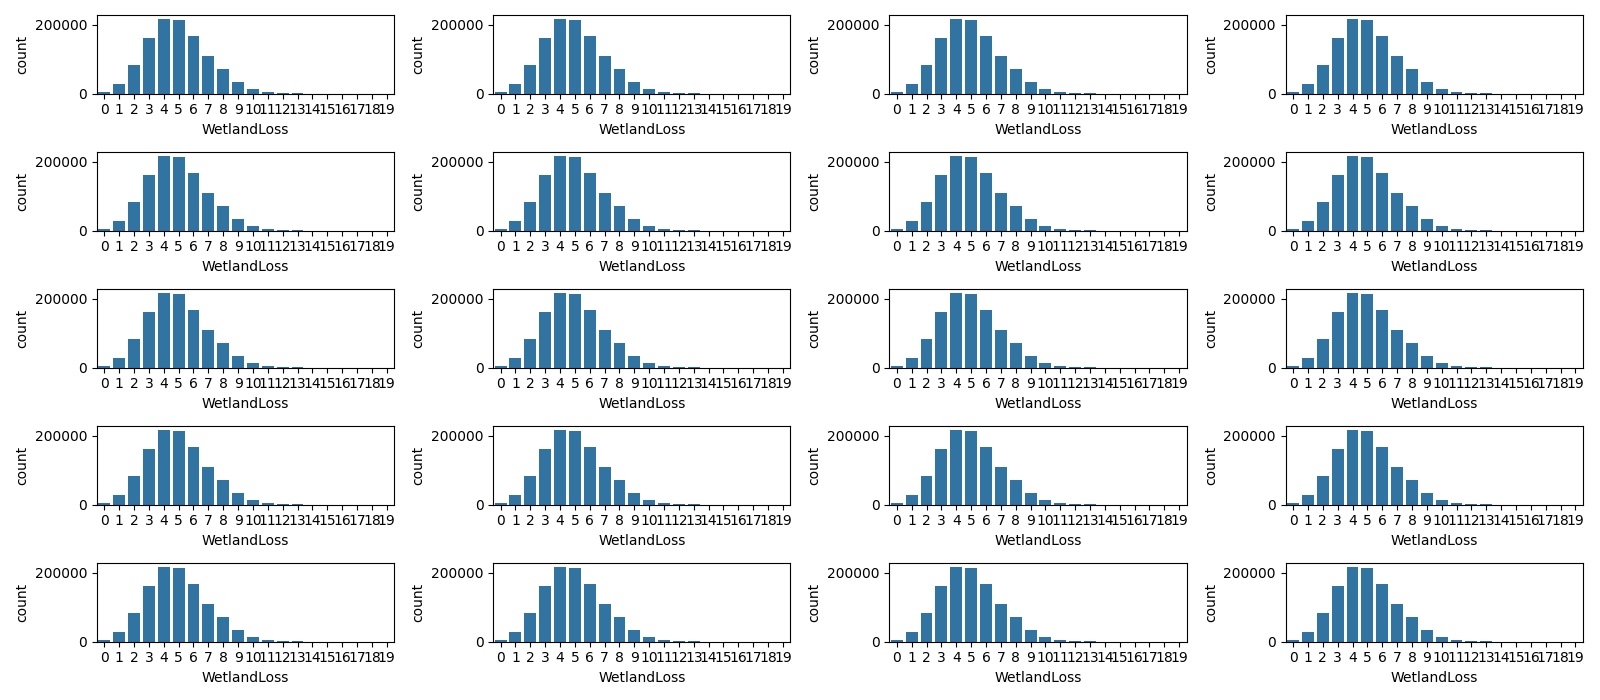

In [9]:
cache_fig(
    'dist_vars', 
    lambda x: [sns.barplot(df_train[i].value_counts(), ax=ax) for ax in x], 
    5, 4, figsize=(16, 7)
)

[Predictor variables come from Poisson(lambda=5) distribution](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499244)
에 의하면 $\lambda=5$인 Poisson 분포를 따른다고 합니다. 정확히 평균을 $lambda$로하여 KS test를 해봅니다.

이 아티클의 내용의 실험결과와 내가 진행한 결과가 다릅니다. pvalue가 너무나 많이 차이가 납니다. 이 아티클에서 진행한 방법은 $\lambda$가 5인 Poisson 분포의 랜덤 변수를 만들어서 비교하는 방법을 사용했습니다. 이 사람이 진행한 방법으로 해도 너무나 많은 차이를 보입니다.

In [10]:
cache_result(
    'kstest_preditor_var', 
    lambda :df_train[X_all].apply(lambda x: kstest(x,  partial(poisson.cdf, mu=x.mean())))
)

,AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,DeterioratingInfrastructure,DrainageSystems,Encroachments,InadequatePlanning,IneffectiveDisasterPreparedness,Landslides,MonsoonIntensity,PoliticalFactors,PopulationScore,RiverManagement,Siltation,TopographyDrainage,Urbanization,Watersheds,WetlandLoss
0,0.199868,0.201176,0.196347,0.199993,0.204266,0.200604,0.200925,0.200044,0.196963,0.198017,0.196231,0.202464,0.195731,0.200289,0.199601,0.201358,0.196726,0.197159,0.197071,0.199654
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
cache_result(
    'kstest_preditor_var_rvs', 
    lambda :df_train[X_all].apply(lambda x: kstest(x,  poisson(mu=x.mean()).rvs(size=len(x))))
)

,AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,DeterioratingInfrastructure,DrainageSystems,Encroachments,InadequatePlanning,IneffectiveDisasterPreparedness,Landslides,MonsoonIntensity,PoliticalFactors,PopulationScore,RiverManagement,Siltation,TopographyDrainage,Urbanization,Watersheds,WetlandLoss
0,2.467716e-02,0.026982,2.133356e-02,2.271823e-02,0.027221,0.028844,2.432026e-02,0.027025,2.436677e-02,2.251518e-02,2.237921e-02,0.029744,2.197312e-02,2.559132e-02,2.284167e-02,0.028759,0.02996,2.439987e-02,0.028063,2.315474e-02
1,3.885316e-296,0.000000,2.001839e-221,4.777410e-251,0.000000,0.000000,1.208448e-287,0.000000,9.603106e-289,1.379075e-246,1.270253e-243,0.000000,7.093240e-235,1.867410e-318,8.871678e-254,0.000000,0.00000,1.579683e-289,0.000000,9.009184e-261


<Axes: xlabel='index', ylabel='value'>

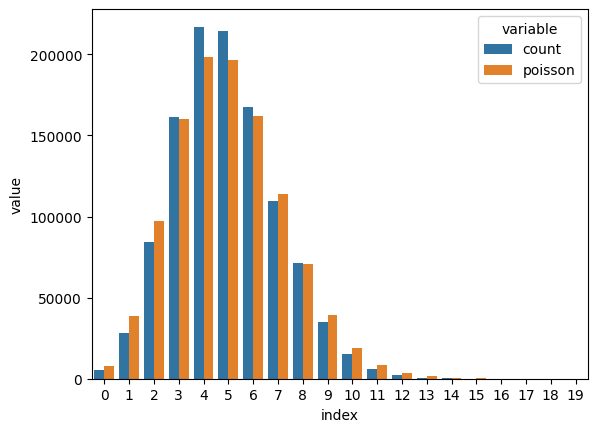

In [12]:
from scipy.stats import kstest, poisson, norm
sns.barplot(
    pd.concat(
        [df_train['WetlandLoss'].value_counts(), 
         pd.Series(poisson(mu=df_train['WetlandLoss'].mean()).rvs(size=len(df_train)), index=df_train.index).value_counts().rename('poisson')],
        axis=1
    ).reset_index().melt(id_vars='index'), x='index', y='value', hue='variable'
)

유사는 하긴 하지만, 육안으로도 차이를 나타냅니다. cdf가 더 적합한 상황인데, 표본을 만들어 검정한 것도 이상합니다.

믿을 만한 분석이라 보긴 힘들다고 판단됩니다.

In [13]:
cache_result(
    'kstest_preditor_var_norm', 
    lambda :df_train[X_all].apply(lambda x: kstest(x,  partial(norm.cdf, loc=x.mean(), scale=x.std())))
)

,AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,DeterioratingInfrastructure,DrainageSystems,Encroachments,InadequatePlanning,IneffectiveDisasterPreparedness,Landslides,MonsoonIntensity,PoliticalFactors,PopulationScore,RiverManagement,Siltation,TopographyDrainage,Urbanization,Watersheds,WetlandLoss
0,0.12522,0.12573,0.126885,0.128522,0.126552,0.125353,0.12695,0.132969,0.129591,0.128821,0.124843,0.126037,0.125677,0.127496,0.126849,0.129296,0.131521,0.126351,0.130025,0.126119
1,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


뭐가 일치하는 건지, 방법에 의구심이 듭니다.

## FloodProbability

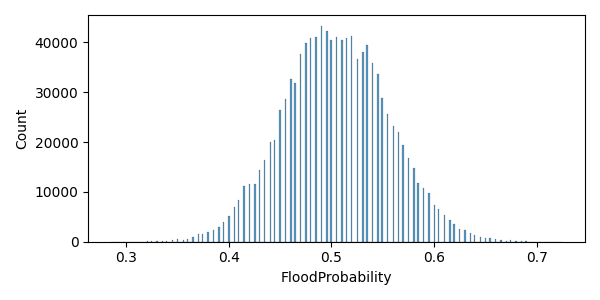

In [14]:
cache_fig(
    'dist_target',
    lambda x: sns.histplot(df_train[target], ax=x),
    1, 1, figsize=(6, 3)
)

In [15]:
df_train[target].value_counts()

FloodProbability
0.490    43320
0.495    42302
0.520    41266
0.485    41156
0.505    41126
         ...  
0.700       32
0.725       29
0.715       26
0.710       23
0.285       20
Name: count, Length: 83, dtype: int64

In [16]:
df_train[target].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
FloodProbability,1117957.0,0.50448,0.051026,0.285,0.47,0.505,0.54,0.725


In [17]:
((df_train[target] * 1000) % 10).value_counts()

FloodProbability
0.0    563257
5.0    554700
Name: count, dtype: int64

In [18]:
from scipy.stats import jarque_bera, kstest, norm

jarque_bera(df_train[target]), kstest(df_train[target], norm.cdf)

(SignificanceResult(statistic=488.6497553253558, pvalue=7.78133010075541e-107),
 KstestResult(statistic=0.6423201749917902, pvalue=0.0, statistic_location=0.385, statistic_sign=-1))

분포상으로 불연속적인 측면이 보입니다.

소수점 세번째 자리수가 0 또는 5입니다.

0.285에서 0.725 사이의 수입니다.

대칭형이여서 혹시 정규분포를 따르는지 확인했지만, 정규분포는 아닙니다.

## Corrleation

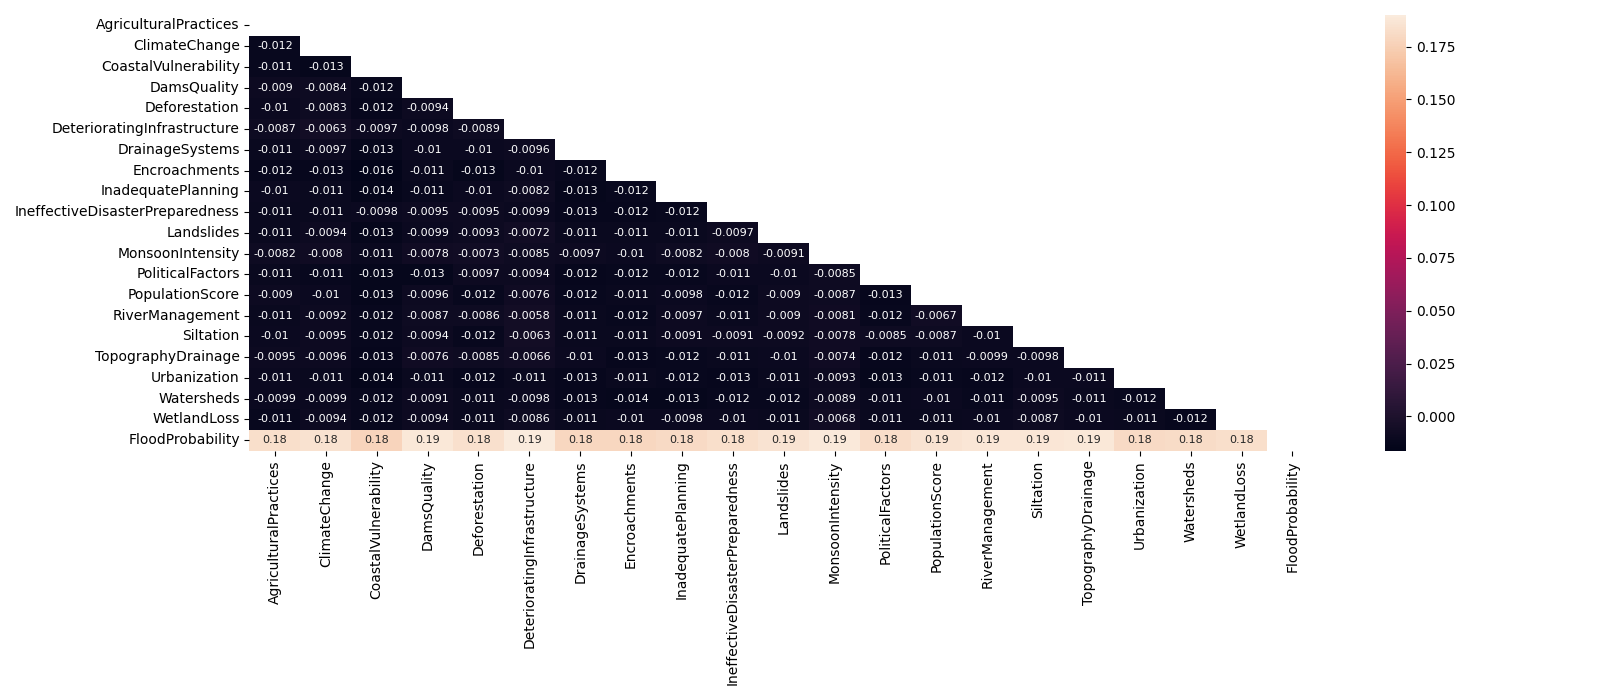

In [19]:
cache_fig('correlation_mat', 
    lambda x: sns.heatmap(
        df_train[X_all + [target]].corr(), mask=np.triu(np.ones_like(df_corr, dtype=bool)), 
        annot=True, annot_kws={"fontsize":8}, ax=x
    ), nrow=1, ncol=1, figsize=(16, 7)
)

입력 변수들 끼리는 선형적 관계가 없고, 대상변수와는 거의 균일한 상관도를 보입니다.

## Exploratory Analysis

### Linear Regression

[PSS4E5 EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/code/ambrosm/pss4e5-eda-which-makes-sense) 에서

모든입력변수의 합으로 FloodProbability를 설명할 수 있다고 했습니다. 선형회귀 모델을 만들어 여기서 비롯된 특성을 살펴봅니다.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score
# 절편이 없을 때 R2: 0.837 있을 때: 0.845
cv_prd = cache_result(
    'cv10_prd_linear_model', 
    lambda : cross_val_predict(LinearRegression(), df_train[X_all], df_train[target], cv=KFold(n_splits=10, random_state=123, shuffle=True))
)
r2_score(df_train[target], cv_prd)

0.844944107460811

In [21]:
s_cv_prd = pd.Series(cv_prd, index=df_train.index, name='lr_prd')
s_residual = (df_train['FloodProbability'] - s_cv_prd).rename('residual')

In [22]:
def get_lr_model():
    reg_lr = LinearRegression().fit(df_train[X_all], df_train[target])
    return reg_lr.coef_, reg_lr.intercept_
cache_result('linear_reg_model', get_lr_model)

(array([0.00563522, 0.00566253, 0.00567088, 0.00565494, 0.00567915,
        0.00561563, 0.00563556, 0.00564989, 0.00560869, 0.0056404 ,
        0.00564163, 0.00561159, 0.0056494 , 0.0056775 , 0.00566643,
        0.00563783, 0.00564756, 0.00565772, 0.0056465 , 0.00563494]),
 -0.05329908699888197)

선형 모델의 회귀계수가 비슷합니다. 위 아티클의 내용대로 FloodProbability를 설명하기에 모든 변수의 합은 적합해 보이긴 합니다.

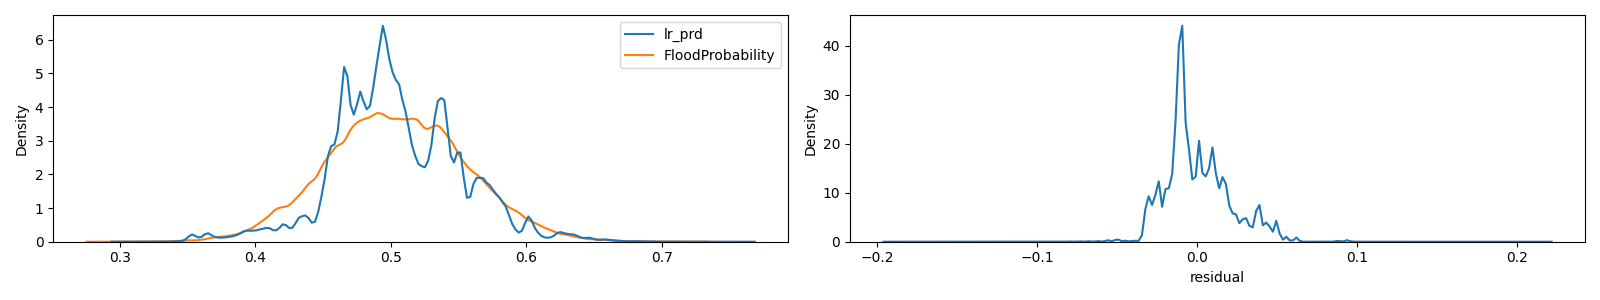

In [23]:
def kde_km_prd_target_residual(axes, s_prd, s_res):
    sns.kdeplot(pd.concat([s_prd, df_train[target]], axis=1), ax=axes[0])
    sns.kdeplot(s_res, ax=axes[1])
    
cache_fig(
    'kde_lm_prd_target_residual',
    lambda x: kde_km_prd_target_residual(x, s_cv_prd, s_residual), nrow=1, ncol=2, figsize=(16, 3)
)

잔차그래프와 예측값의 분포로 보아서는 선형 회귀 모델만으로 대상 변수를 설명하기엔 부족한 점이 보입니다.

여기서 설명하지 못하는 것을 설명할 방안을 찾아봅니다.

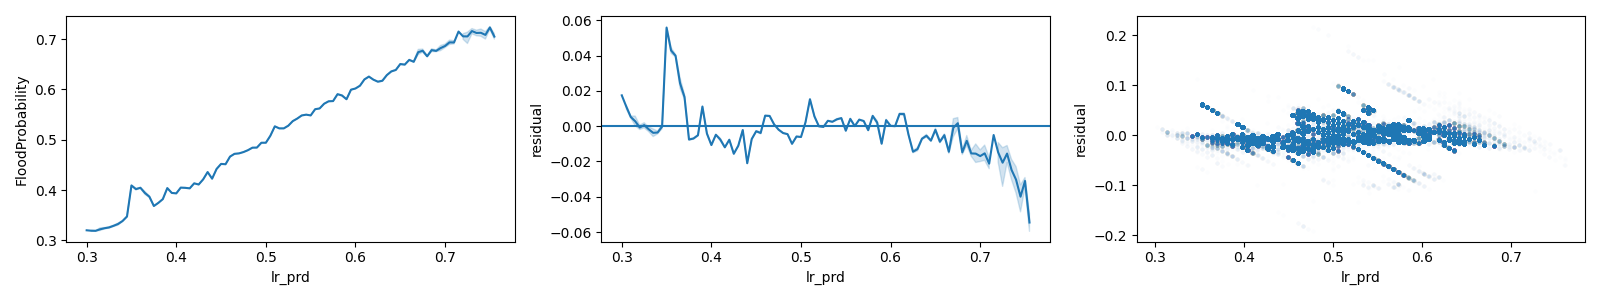

In [24]:
cache_fig('lm_diff_graph', partial(diff_graph, s_prd=s_cv_prd, s_res=s_residual), nrow=1, ncol=3, figsize=(16, 3))

잔차와 예측값의 산포도 그래프를 보면, 비슷한 기울기로 직선형태로 몰려 있는 것을 확인할 수 있습니다. 

잔차가 lr_prd에 정확히 비례해서 차이나는 패턴이 보입니다.

### s_values in [72, 73, 74, 75]

[PSS4E5 EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/code/ambrosm/pss4e5-eda-which-makes-sense)의 Advanced models with feature engineering에서 s_values 72, 73, 74, 75 값 위에서는 lr_prd가 0.35 ~ 0.38인 지점이 FloodProbability가 높은 경향이 강하게 나타남을 확인할 수 있습니다. 이 구간을 속성으로 만들어 봅니다.

In [25]:
# 절편이 없을 때 R2: 0.837 있을 때: 0.845
cv_prd2 = cache_result(
    'cv10_prd_linear_model2', 
    lambda : cross_val_predict(
        LinearRegression(), 
        df_train[X_all].assign(special1=lambda x: x['s_values'].isin([72, 73, 74, 75])), 
        df_train[target], cv=KFold(n_splits=10, random_state=123, shuffle=True))
)
r2_score(df_train[target], cv_prd2)

0.8514600610998475

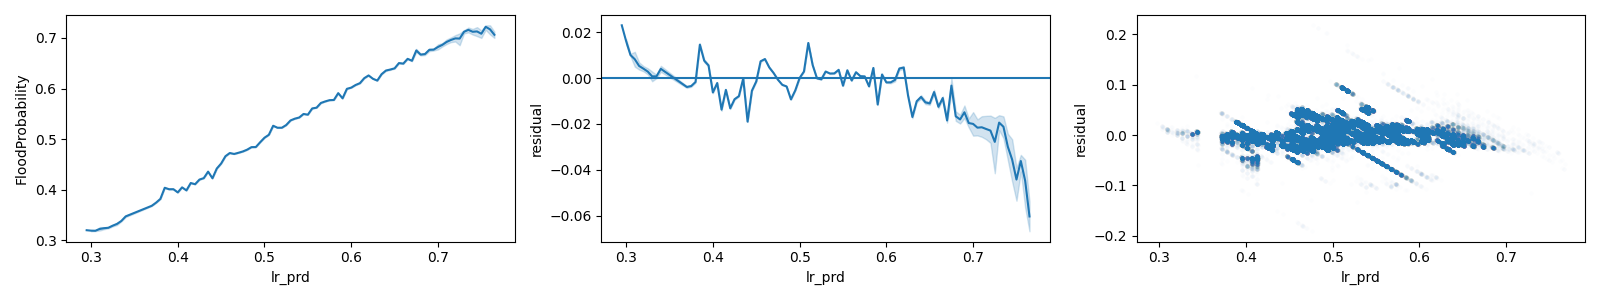

In [26]:
s_cv_prd = pd.Series(cv_prd2, index=df_train.index, name='lr_prd')
s_residual = (df_train['FloodProbability'] - s_cv_prd).rename('residual')
cache_fig('lm2_diff_graph', partial(diff_graph, s_prd=s_cv_prd, s_res=s_residual), nrow=1, ncol=3, figsize=(16, 3))

special1을 data processing 과정에 포함시킨다.

### s_values와 s_values2 그리고, special1 속성만을 사용한다면?

In [27]:
# 절편이 없을 때 R2: 0.837 있을 때: 0.845
cv_prd3 = cache_result(
    'cv10_prd_linear_model3', 
    lambda : cross_val_predict(
        LinearRegression(), 
        df_train[['s_values', 's_values2', 'special1']], 
        df_train[target], cv=KFold(n_splits=10, random_state=123, shuffle=True))
    ,rerun=True
)
r2_score(df_train[target], cv_prd3)

0.8513292291900585

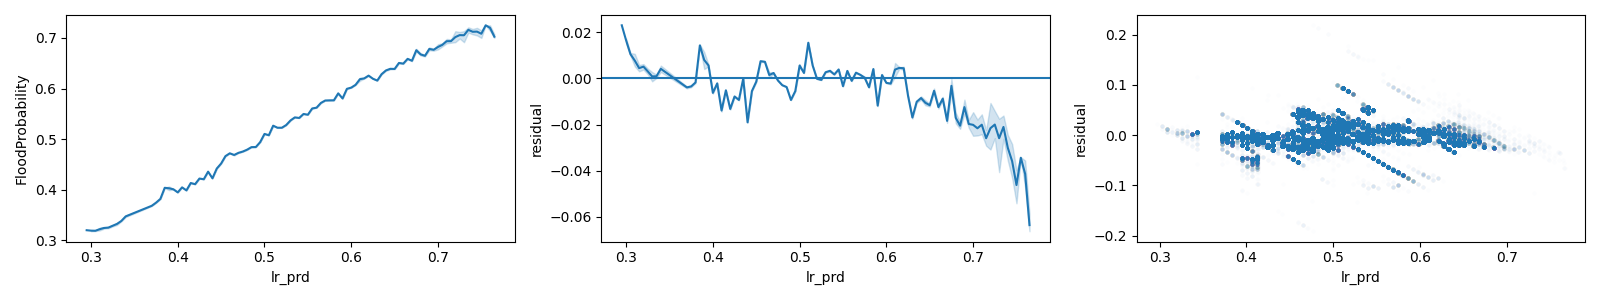

In [28]:
s_cv_prd = pd.Series(cv_prd3, index=df_train.index, name='lr_prd')
s_residual = (df_train['FloodProbability'] - s_cv_prd).rename('residual')
cache_fig('lm3_diff_graph', partial(diff_graph, s_prd=s_cv_prd, s_res=s_residual), nrow=1, ncol=3, figsize=(16, 3))

lr_prd가 0.6이 넘어선 시점이 되면 residual의 평균이 점차 음의 방향이 된다.  이러한 현상이 R2에 주는 영향은?

In [29]:
1 - (s_residual.loc[s_cv_prd < 0.63] ** 2).sum() / ((df_train['FloodProbability']  - df_train['FloodProbability'].mean()) ** 2).sum()

0.8526296382561863

## PLSRegression (Partial Least Square Regression)

PLS 모델이 유용할 지를 살펴 봅니다.

In [30]:
from sklearn.cross_decomposition import PLSRegression

def PLS_check():
    reg_pls = PLSRegression(n_components=2)
    reg_pls.fit(df_train[X_num_org], df_train[target])
    return r2_score(df_train[target], reg_pls.predict(df_train[X_num_org]))

cache_result('PLS_check', PLS_check)

0.8449501105396167

아주 미약한 효과만 존재합니다.

## 선형 모델과 평행을 이루는 현상을 살펴 봅니다.

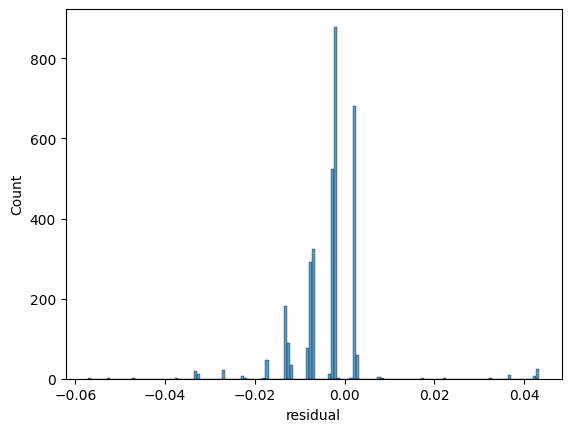

In [31]:
# 첫 번째 두드러지게 차이를 보이는 지점을 살펴봅니다.
sns.histplot(s_residual[s_cv_prd.between(0.35, 0.38)])
plt.show()

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
df_train.loc[s_cv_prd.between(0.35, 0.38)].assign(
    diff = lambda x: s_residual.loc[x.index] < 0.02
).pipe(lambda x: cross_val_score(LogisticRegression(), x[X_num_org], x['diff'], scoring='accuracy'))

array([0.98796992, 0.98646617, 0.98646617, 0.98795181, 0.98795181])

In [33]:
clf_lr = df_train.loc[s_cv_prd.between(0.35, 0.38)].assign(
    diff = lambda x: s_residual.loc[x.index] < 0.02
).pipe(lambda x: LogisticRegression().fit(x[X_num_org], x['diff']))

In [34]:
clf_lr.coef_, clf_lr.intercept_

(array([[ 0.00257152,  0.21688118,  0.07593618,  0.02838246,  0.03045992,
         -0.03555185, -0.04161475,  0.02778243, -0.01890149,  0.1421856 ,
          0.21912974, -0.02111745,  0.10417915,  0.24378838,  0.06742736,
          0.14032669, -0.09154586, -0.01300474,  0.06272194,  0.06528888]]),
 array([0.01269945]))

로지스틱 회귀 모델의 계수가 비슷합니다.

X_num_org 변수들의 합으로 구분점을 표현할 수 있습니다.

## LightGBM


In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score
cv10 = KFold(n_splits=10, random_state=123, shuffle=True)
cv_prd_lgb = cache_result(
    'cv10_prd_lgbm', 
    lambda : cross_val_predict(lgb.LGBMRegressor(verbose=-1), df_train[X_num_org], df_train[target], cv=cv10)
)
r2_score(df_train[target], cv_prd_lgb)

0.7667317936366107

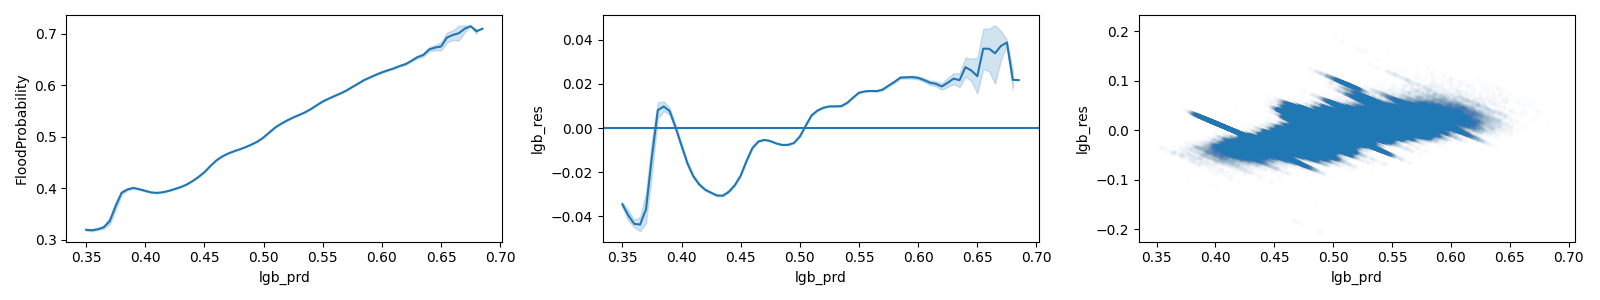

In [36]:
s_cv_prd_lgb = pd.Series(cv_prd_lgb, index=df_train.index, name='lgb_prd')
s_res_lgb = (df_train[target] - s_cv_prd_lgb).rename('lgb_res')
cache_fig('lgb_diff_graph', partial(diff_graph, s_prd=s_cv_prd_lgb, s_res=s_res_lgb), nrow=1, ncol=3, figsize=(16, 3))

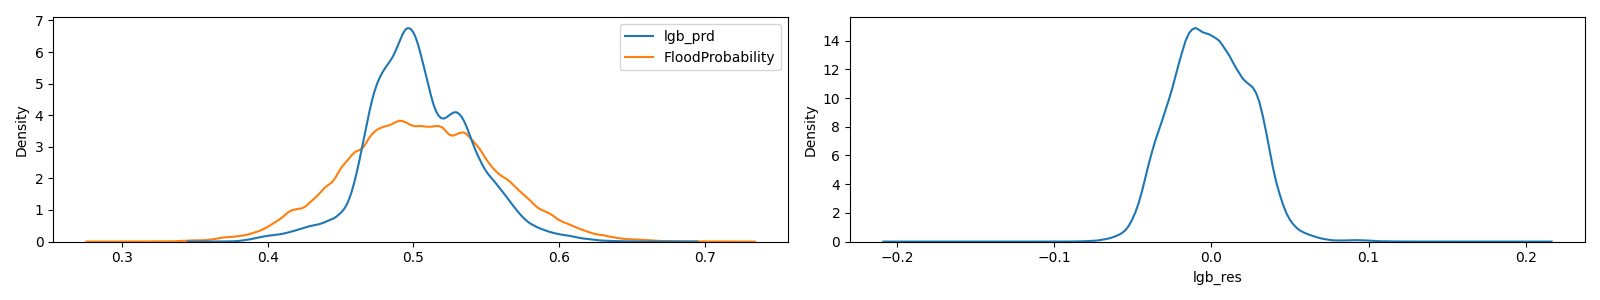

In [37]:
cache_fig(
    'kde_lgb_prd_target_residual',
    lambda x: kde_km_prd_target_residual(x, s_cv_prd_lgb, s_res_lgb), nrow=1, ncol=2, figsize=(16, 3)
)

In [38]:
from scipy.stats import spearmanr
cache_result(
    's_reg_lgb_spearman_corr',
    lambda : df_train[X_all].apply(lambda x: spearmanr(x, s_res_lgb))
)

,AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,DeterioratingInfrastructure,DrainageSystems,Encroachments,InadequatePlanning,IneffectiveDisasterPreparedness,...,sort_11,sort_12,sort_13,sort_14,sort_15,sort_16,sort_17,sort_18,sort_19,s_values
0,0.088659,0.089958,0.089032,0.089875,0.089454,0.089864,0.089159,0.0895,0.089489,0.089607,...,0.305498,0.298155,0.291122,0.295545,0.295293,0.296379,0.306316,0.309385,0.269625,0.50046
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


#### s_values를 추가해봅니다.

In [39]:
cv_prd_lgb2 = cache_result(
    'cv10_prd_lgbm2', 
    lambda : cross_val_predict(
        lgb.LGBMRegressor(verbose=-1), df_train[X_num_org + ['s_values']], df_train[target], 
        cv=cv10
    )
)
r2_score(df_train[target], cv_prd_lgb2)

0.8672303078875047

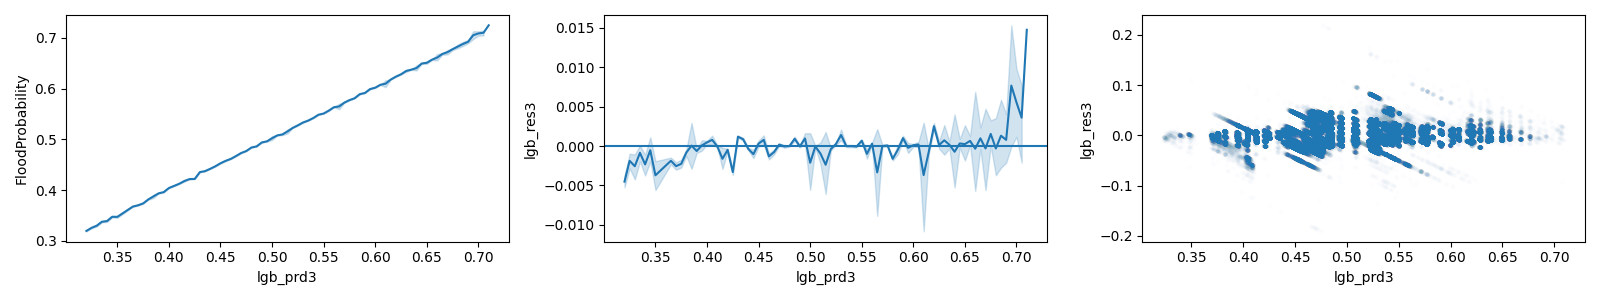

In [40]:
s_cv_prd_lgb2 = pd.Series(cv_prd_lgb2, index=df_train.index, name='lgb_prd2')
s_res_lgb2 = (df_train[target] - s_cv_prd_lgb2).rename('lgb_res2')
cache_fig('lgb2_diff_graph', partial(diff_graph, s_prd=s_cv_prd_lgb2, s_res=s_res_lgb2), 
          nrow=1, ncol=3, figsize=(16, 3))

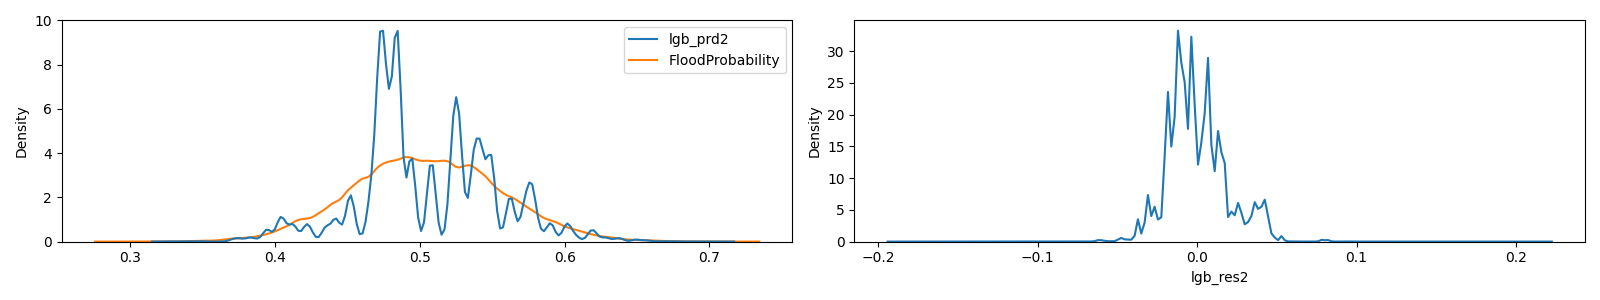

In [41]:
cache_fig(
    'kde_lgb_prd_target_residual2',
    lambda x: kde_km_prd_target_residual(x, s_cv_prd_lgb2, s_res_lgb2), nrow=1, ncol=2, figsize=(16, 3)
)

In [42]:
from scipy.stats import spearmanr
cache_result(
    's_reg_lgb2_spearman_corr',
    lambda : df_train[X_all].apply(lambda x: spearmanr(x, s_res_lgb2))
)

,AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,DeterioratingInfrastructure,DrainageSystems,Encroachments,InadequatePlanning,IneffectiveDisasterPreparedness,...,sort_11,sort_12,sort_13,sort_14,sort_15,sort_16,sort_17,sort_18,sort_19,s_values
0,0.003836,5.136923e-03,6.015214e-03,4.729523e-03,6.434959e-03,4.678788e-03,5.196252e-03,0.004579,5.130139e-03,0.004118,...,1.949305e-02,1.992215e-02,1.775459e-02,1.821841e-02,2.104030e-02,1.878373e-02,1.786943e-02,2.288521e-02,1.718938e-02,0.038606
1,0.000050,5.588938e-08,2.015626e-10,5.711892e-07,1.017749e-11,7.534017e-07,3.924640e-08,0.000001,5.818082e-08,0.000013,...,2.114681e-94,1.616081e-98,1.232413e-78,1.066248e-82,1.151214e-109,8.606037e-88,1.242944e-79,2.199514e-129,7.958314e-74,0.000000


In [43]:
# 행기준 정렬을 통한 속성 추가에 대한 성능힙니다.
cv_prd_lgb3 = cache_result(
    'cv10_prd_lgbm3', 
    lambda : cross_val_predict(
        lgb.LGBMRegressor(verbose=-1), df_train[X_num_org + X_sort + ['s_values']], df_train[target], 
        cv=cv10
    )
)
r2_score(df_train[target], cv_prd_lgb3)

0.8687900193198241

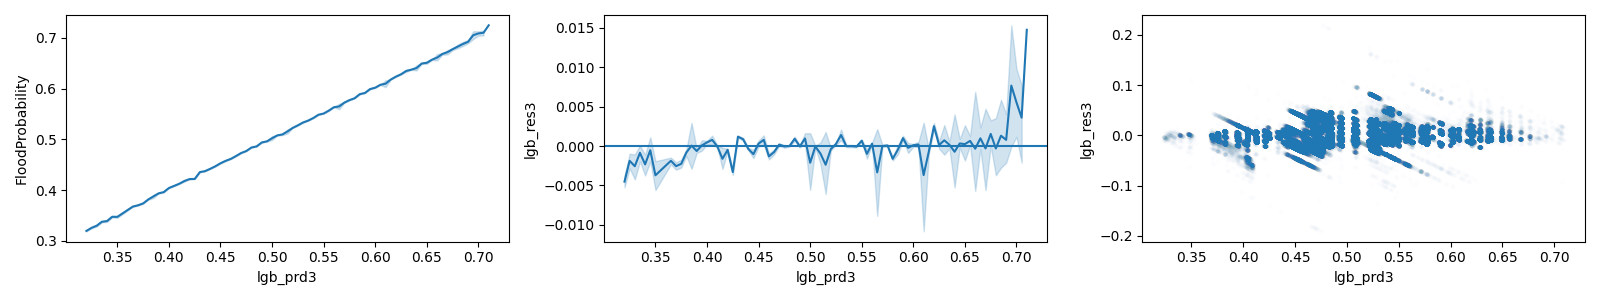

In [44]:
s_cv_prd_lgb3 = pd.Series(cv_prd_lgb3, index=df_train.index, name='lgb_prd3')
s_res_lgb3 = (df_train[target] - s_cv_prd_lgb3).rename('lgb_res3')
cache_fig('lgb2_diff_graph', partial(diff_graph, s_prd=s_cv_prd_lgb3, s_res=s_res_lgb3), 
          nrow=1, ncol=3, figsize=(16, 3))

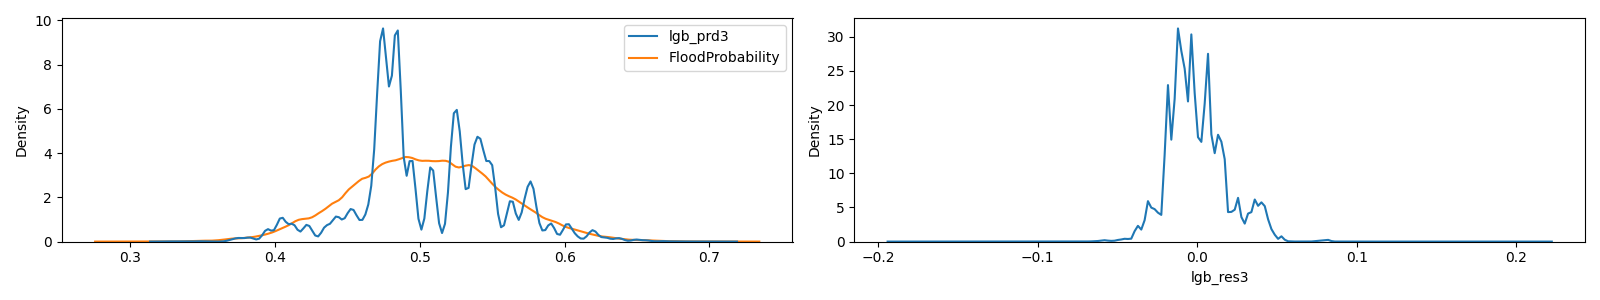

In [45]:
cache_fig(
    'kde_lgb_prd_target_residual3',
    lambda x: kde_km_prd_target_residual(x, s_cv_prd_lgb3, s_res_lgb3), nrow=1, ncol=2, figsize=(16, 3)
)

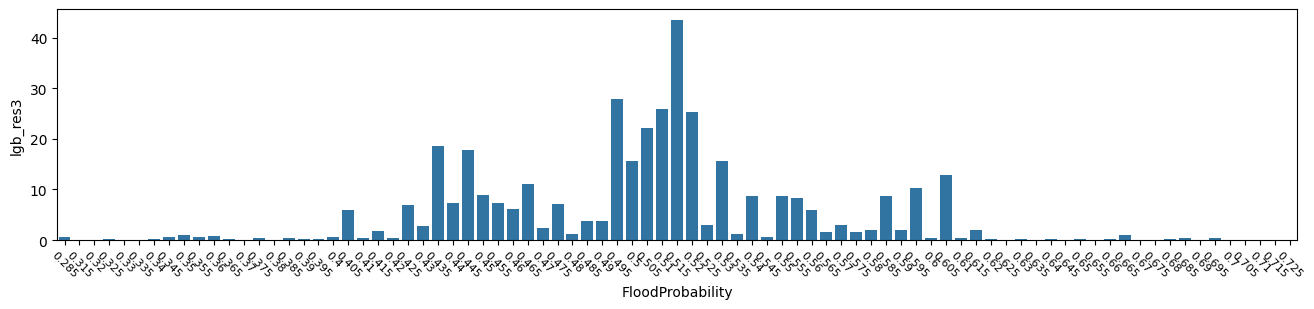

In [46]:
plt.figure(figsize=(16, 3))
sns.barplot((s_res_lgb3 ** 2).groupby(df_train[target]).sum())
plt.xticks(rotation=-45, fontsize=8)
plt.show()

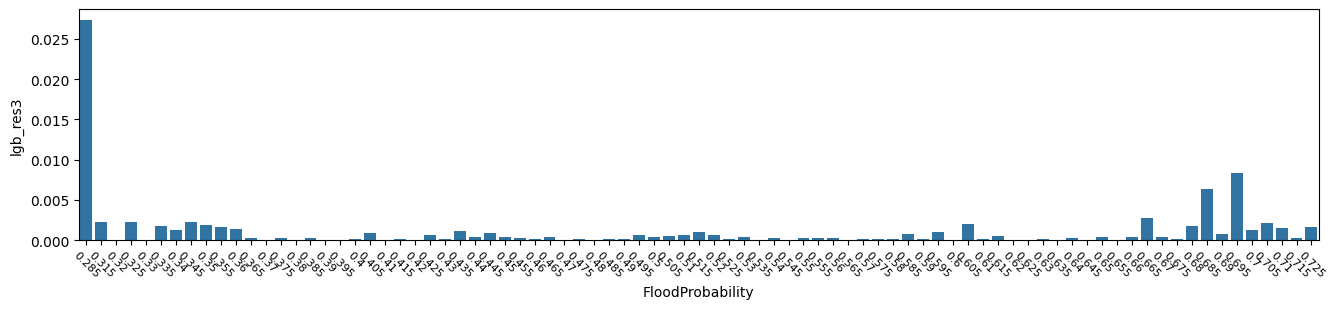

In [47]:
plt.figure(figsize=(16, 3))
sns.barplot((s_res_lgb3 ** 2).groupby(df_train[target]).mean())
plt.xticks(rotation=-45, fontsize=8)
plt.show()

### FloodProbability와 밀도가 차이가 많이 나는 구간을 집중해서 봅니다.

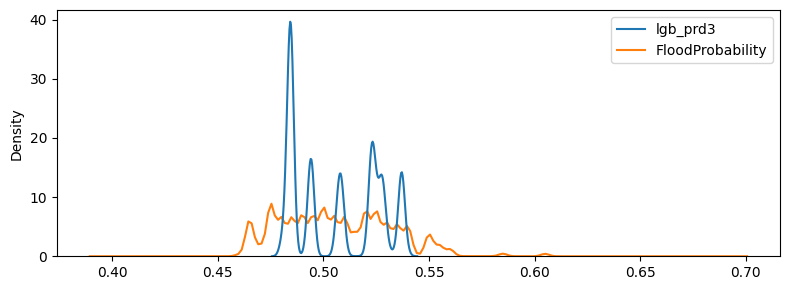

In [48]:
cache_fig('confusing_prob1',
    lambda x: sns.kdeplot(pd.concat([s_cv_prd_lgb3, df_train[target]], axis=1).pipe(lambda x: x.loc[s_cv_prd_lgb3.between(0.48, 0.54)])),
    nrow=1, ncol=1, figsize=(8, 3), redraw=True
)

In [49]:
df_tmp = pd.concat([s_res_lgb3, df_train], axis=1).pipe(lambda x: x.loc[s_cv_prd_lgb3.between(0.48, 0.54)])
cross_val_score(lgb.LGBMRegressor(verbose=-1), df_tmp[X_num_org], df_tmp['lgb_res3'], scoring='r2', cv=5)

array([-0.0012513 , -0.00123983, -0.00140251, -0.00125625, -0.00141303])

## s_values를 가지고 lgb.LGBMRegressor로 모델을 만들어 보자.

In [50]:
# 행기준 정렬을 통한 속성 추가에 대한 성능힙니다.
cv_prd_lgb4 = cache_result(
    'cv10_prd_lgbm4', 
    lambda : cross_val_predict(
        lgb.LGBMRegressor(verbose=-1), df_train[['s_values']], df_train[target], 
        cv=cv10
    )
)
r2_score(df_train[target], cv_prd_lgb4)

0.8657851430145668

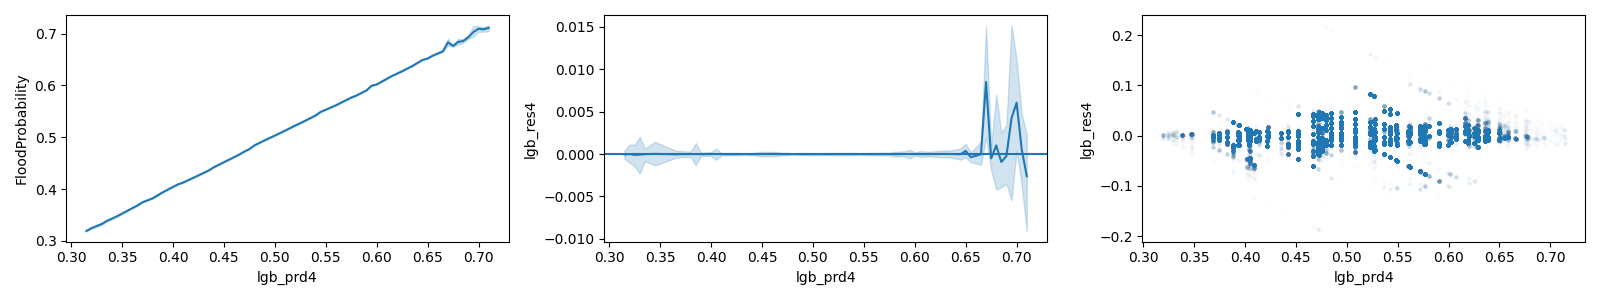

In [51]:
s_cv_prd_lgb4 = pd.Series(cv_prd_lgb4, index=df_train.index, name='lgb_prd4')
s_res_lgb4 = (df_train[target] - s_cv_prd_lgb4).rename('lgb_res4')
cache_fig('lgb4_diff_graph', partial(diff_graph, s_prd=s_cv_prd_lgb4, s_res=s_res_lgb4), 
          nrow=1, ncol=3, figsize=(16, 3))

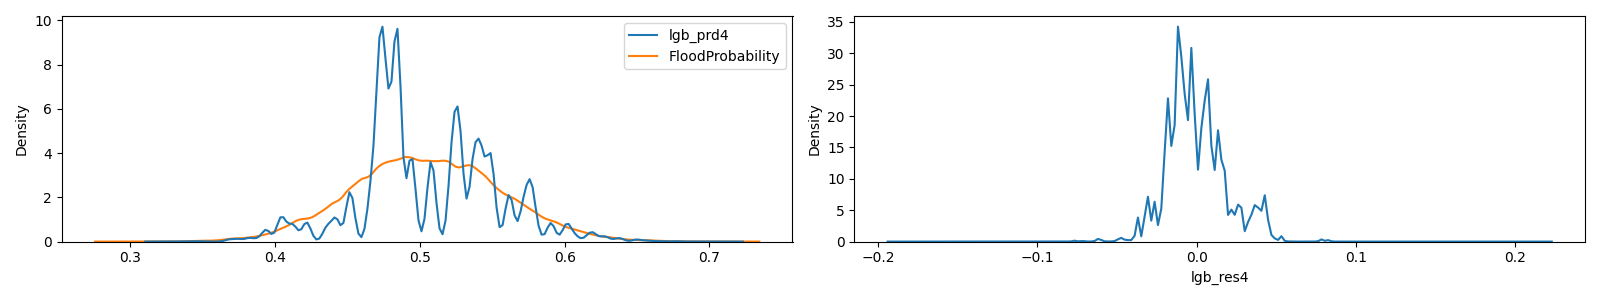

In [52]:
cache_fig(
    'kde_lgb_prd_target_residual4',
    lambda x: kde_km_prd_target_residual(x, s_cv_prd_lgb4, s_res_lgb4), nrow=1, ncol=2, figsize=(16, 3)
)

In [53]:
cache_result(
    'lgb_s_values_r2',
    lambda : r2_score(
        df_train[target], 
        lgb.LGBMRegressor(verbose=-1).fit(df_train[['s_values']], df_train[target]).predict(df_train[['s_values']])
    )
)

0.8657959758724219

0.03 정도 차이가 납니다. s_cv_prd_lgb4 의 구간이 0.56과 0.59에서의 잔차와의 선형적 패턴이 보입니다.

이를 구분할 수 있는 모델을 찾아봅니다.

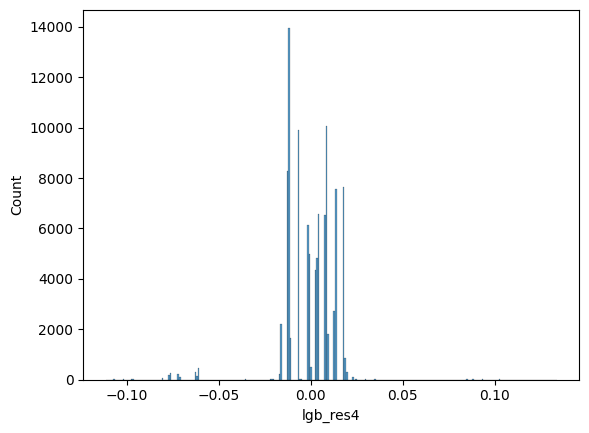

In [55]:
sns.histplot(s_res_lgb4.loc[s_cv_prd_lgb4.between(0.56, 0.59)])
plt.show()

In [56]:
# 각 변수의 제곱의 합으로 분류점이 만들어 집니다.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
df_res_lgb4 = pd.concat([df_train, s_res_lgb4], axis=1).loc[s_cv_prd_lgb4.between(0.56, 0.59)].assign(
    t = lambda x: x['lgb_res4'] < -0.05
)
df_res_lgb4.pipe(
    lambda x: cross_val_score(
        make_pipeline(StandardScaler(), LogisticRegression()),
                (x[X_num_org] ** 2).sum(axis=1).to_frame(), x['t'], scoring='roc_auc', cv=5)
)

array([0.8866236 , 0.89438715, 0.87731453, 0.88748511, 0.87823074])

In [57]:
# 제곱근의 합을 추가해봅니다.
cv_prd_lgb5 = cache_result(
    'cv10_prd_lgbm5', 
    lambda : cross_val_predict(
        lgb.LGBMRegressor(verbose=-1), 
        df_train[['s_values', 's_values2']], df_train[target], 
        cv=KFold(n_splits=10, random_state=123, shuffle=True)
    )
)
r2_score(df_train[target], cv_prd_lgb5)

0.8675772160237383

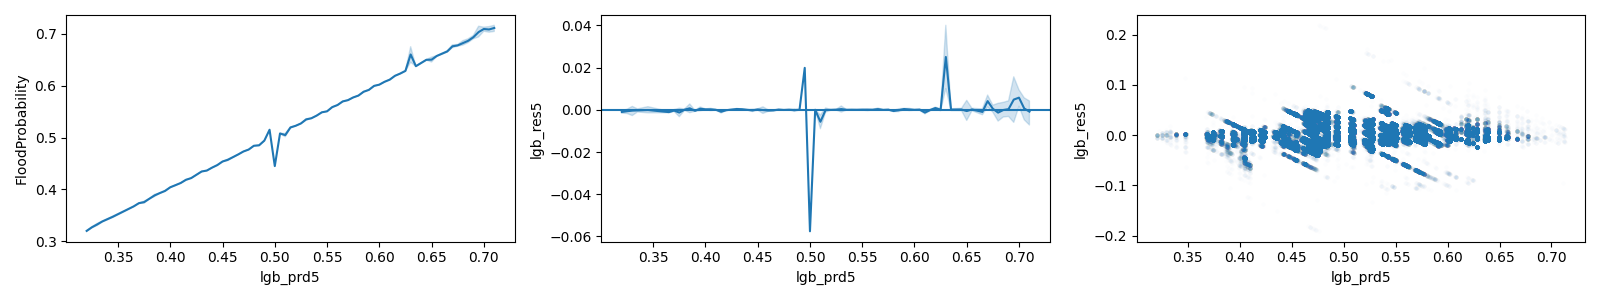

In [58]:
s_cv_prd_lgb5 = pd.Series(cv_prd_lgb5, index=df_train.index, name='lgb_prd5')
s_res_lgb5 = (df_train[target] - s_cv_prd_lgb5).rename('lgb_res5')
cache_fig('lgb5_diff_graph', partial(diff_graph, s_prd=s_cv_prd_lgb5, s_res=s_res_lgb5), 
          nrow=1, ncol=3, figsize=(16, 3))

입력 변수의 제곱의 합과 원래 변수를 제외하고 행단위 정렬 속성을 사용했을 때 성능의 향상이 있습니다.

In [59]:
cv_prd_lgb6 = cache_result(
    'cv10_prd_lgbm6', 
    lambda : cross_val_predict(
        lgb.LGBMRegressor(verbose=-1), 
        df_train[X_sort + ['s_values', 's_values2']], df_train[target], 
        cv=KFold(n_splits=10, random_state=123, shuffle=True)
    )
)
r2_score(df_train[target], cv_prd_lgb6)

0.8689457987726035

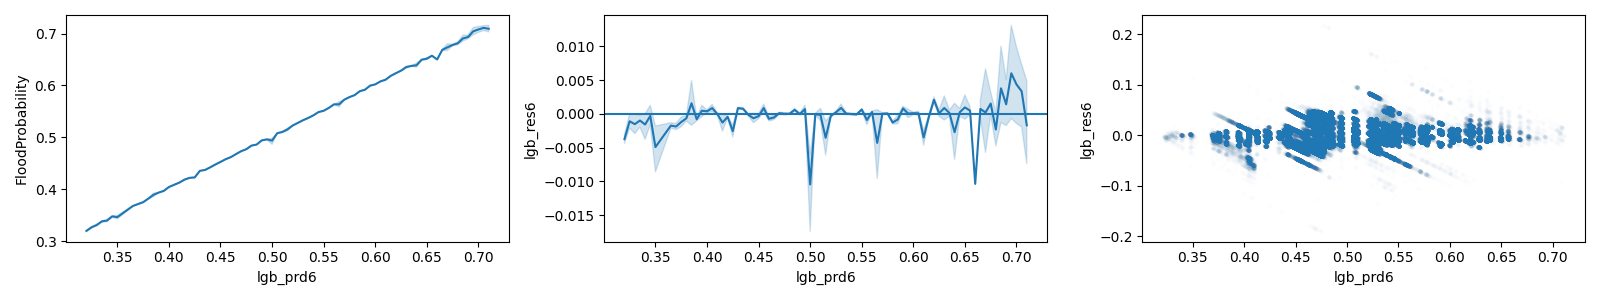

In [60]:
s_cv_prd_lgb6 = pd.Series(cv_prd_lgb6, index=df_train.index, name='lgb_prd6')
s_res_lgb6 = (df_train[target] - s_cv_prd_lgb6).rename('lgb_res6')
cache_fig('lgb6_diff_graph', partial(diff_graph, s_prd=s_cv_prd_lgb6, s_res=s_res_lgb6), 
          nrow=1, ncol=3, figsize=(16, 3))

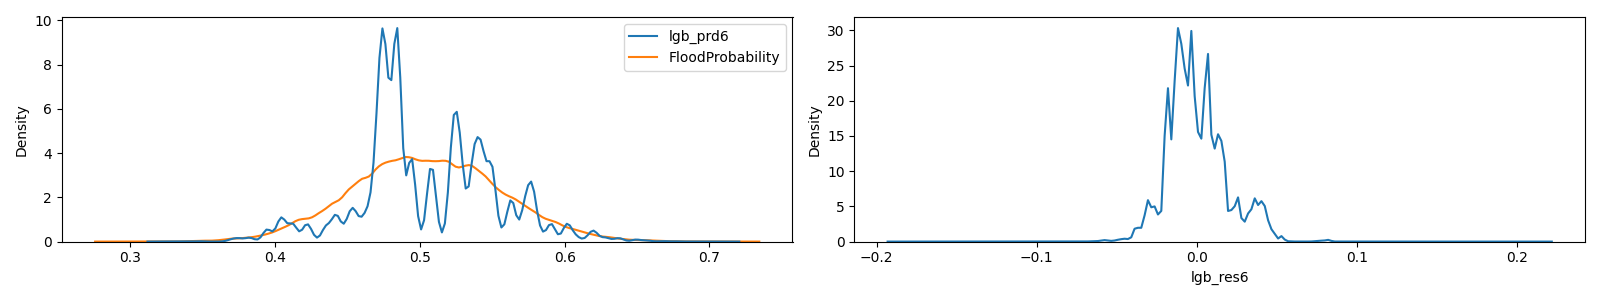

In [61]:
cache_fig(
    'kde_lgb_prd_target_residual6',
    lambda x: kde_km_prd_target_residual(x, s_cv_prd_lgb6, s_res_lgb6), nrow=1, ncol=2, figsize=(16, 3)
)

<Axes: xlabel='lgb_res6', ylabel='Count'>

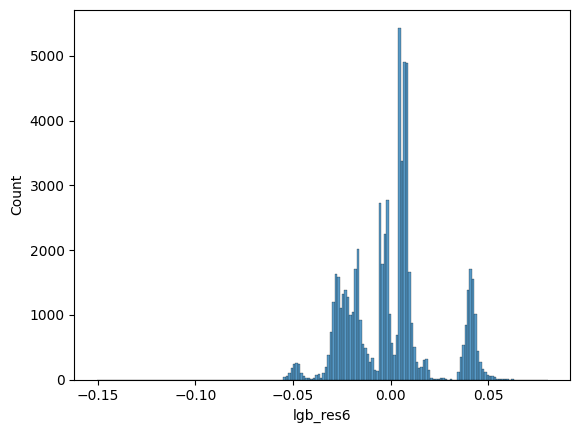

In [62]:
sns.histplot(s_res_lgb6.loc[s_cv_prd_lgb6.between(0.43, 0.46)])

In [63]:
# 각 변수의 제곱의 합으로 분류점이 만들어 집니다.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
df_res_lgb6 = pd.concat([df_train, s_res_lgb6], axis=1).loc[s_cv_prd_lgb6.between(0.43, 0.46)].assign(
    t = lambda x: x['lgb_res6'] < 0.03
)
df_res_lgb6.pipe(
    lambda x: cross_val_score(
        make_pipeline(StandardScaler(), LogisticRegression()),
                x[['s_values', 's_values2']], x['t'], scoring='roc_auc', cv=5)
)

array([0.77505906, 0.7736144 , 0.77030126, 0.77566203, 0.7721377 ])

### 원래 입력변수의 순위는 어떤 효과가 있을까


In [64]:
# 행기준 정렬을 통한 속성 추가에 대한 성능힙니다.
cv_prd_lgb4 = cache_result(
    'cv10_prd_lgbm4', 
    lambda : cross_val_predict(
        lgb.LGBMRegressor(verbose=-1), 
        pd.concat([
            df_train[X_num_org + X_sort + ['s_values']], 
            df_train[X_num_org].rank(axis=1).rename(columns=lambda x: x + '_rnk')
        ], axis=1), df_train[target],
        cv=KFold(n_splits=10, random_state=123, shuffle=True)
    )
)
r2_score(df_train[target], cv_prd_lgb4)

0.8657851430145668

In [65]:
# 행기준 정렬을 통한 속성 추가에 대한 성능힙니다.
cv_prd_lgb4_2 = cache_result(
    'cv10_prd_lgbm4_2', 
    lambda : cross_val_predict(
        lgb.LGBMRegressor(verbose=-1), 
        pd.concat([
            df_train[X_sort + ['s_values', 's_values2']], 
            df_train[X_num_org].rank(axis=1).rename(columns=lambda x: x + '_rnk')
        ], axis=1), df_train[target],
        cv=KFold(n_splits=10, random_state=123, shuffle=True)
    )
)
r2_score(df_train[target], cv_prd_lgb4_2)

0.8688211395467379

효과가 없어 보입니다.

### 입력변수의 표준편차

In [66]:
cv_prd_lgb4_std = cache_result(
    'cv10_prd_lgbm4_std', 
    lambda : cross_val_predict(
        lgb.LGBMRegressor(verbose=-1), 
        pd.concat([
            df_train[X_sort + ['s_values', 's_values2']], 
            df_train[X_num_org].std(axis=1).rename('std'),
        ], axis=1), df_train[target],
        cv=KFold(n_splits=10, random_state=123, shuffle=True)
    )
)
r2_score(df_train[target], cv_prd_lgb4_std)

0.8689578054726537

0.0001의 효과가 보입니다.

### 입력 변수의 왜도

In [67]:
cv10_prd_lgbm4_skew = cache_result(
    'cv10_prd_lgbm4_skew', 
    lambda : cross_val_predict(
        lgb.LGBMRegressor(verbose=-1), 
        pd.concat([
            df_train[X_sort + ['s_values', 's_values2']], 
            df_train[X_num_org].std(axis=1).rename('std'),
            df_train[X_num_org].skew(axis=1).rename('skew'),
        ], axis=1), df_train[target],
        cv=KFold(n_splits=10, random_state=123, shuffle=True)
    )
)
r2_score(df_train[target], cv10_prd_lgbm4_skew)

0.8689670614981504

0.0001의 효과가 보입니다.

### 입력 변수의 첨도

In [68]:
cv10_prd_lgbm4_kurt = cache_result(
    'cv10_prd_lgbm4_kurt', 
    lambda : cross_val_predict(
        lgb.LGBMRegressor(verbose=-1), 
        pd.concat([
            df_train[X_sort + ['s_values', 's_values2']], 
            df_train[X_num_org].std(axis=1).rename('std'),
            df_train[X_num_org].skew(axis=1).rename('skew'),
            df_train[X_num_org].kurt(axis=1).rename('kurt'),
        ], axis=1), df_train[target],
        cv=KFold(n_splits=10, random_state=123, shuffle=True)
    )
)
r2_score(df_train[target], cv10_prd_lgbm4_kurt)

0.8689518742807649

성능이 떨어집니다.

## Neural Network

In [69]:
import sgnn
import sgml
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

2024-05-21 08:47:56.920826: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 08:47:57.538051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [70]:
# 신경망의 원활한 학습을 위해서는 표준화가 필요합니다. 
# 또한, 깊은 신경망을 사용해야 
def nn_fit_predict():
    reg_nn = Pipeline([
        ('std', StandardScaler()), 
        ('sgnn', sgnn.NNRegressor([
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True}
        ],
        batch_size=1024,
        shuffle_size=2048000,
        verbose=0,
        validation_fraction=0.1,
        learning_rate=0.001,
        reduce_lr_on_plateau={'factor': 0.1, 'patience': 5},
        early_stopping={'patience': 5},
        epochs=150
    ))])
    reg_nn.fit(df_train[X_sort + ['s_values', 's_values2']], df_train[target], sgnn__metrics=[tf.keras.metrics.R2Score()])
    return reg_nn.predict(df_train[X_sort + ['s_values', 's_values2']])
nn_prd = cache_result('nn_fit_predict', nn_fit_predict)

In [71]:
r2_score(df_train[target], nn_prd)

0.8612846082346182

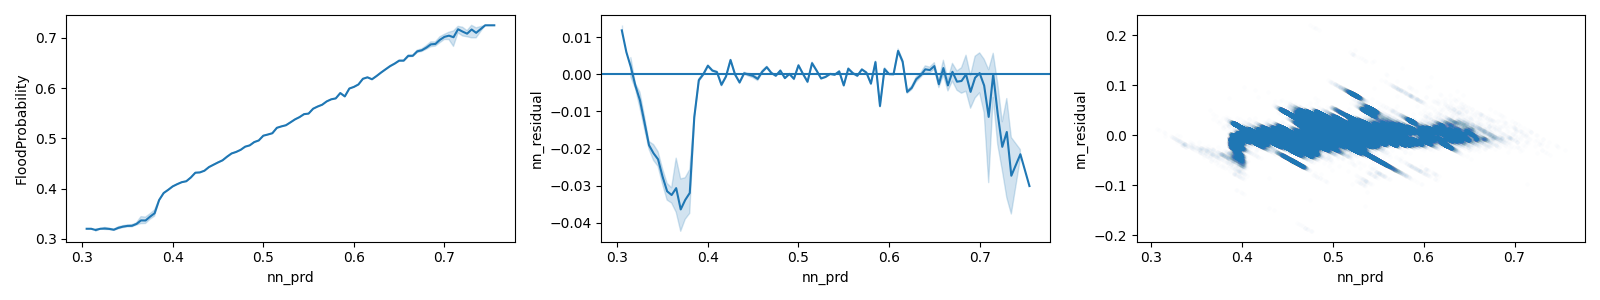

In [72]:
s_nn_prd = pd.Series(nn_prd, index=df_train.index, name='nn_prd')
s_nn_residual = (df_train[target] - s_nn_prd).rename('nn_residual')
cache_fig(
    'nn_diff_graph', 
    partial(diff_graph, s_prd=s_nn_prd, s_res=s_nn_residual), 
    nrow=1, ncol=3, figsize=(16, 3)
)

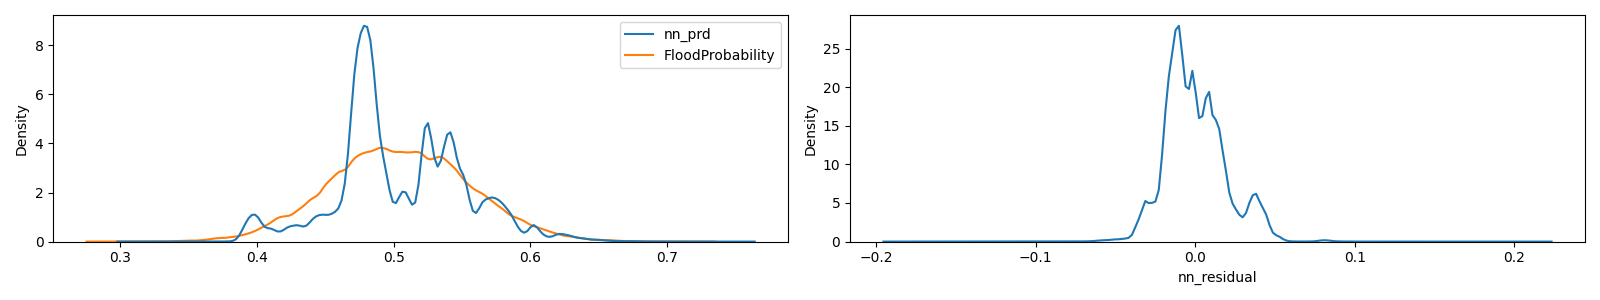

In [74]:
cache_fig(
    'kde_lm_prd_target_residual_nn',
    lambda x: kde_km_prd_target_residual(x, s_nn_prd, s_nn_residual), nrow=1, ncol=2, figsize=(16, 3)
)

### special1 속성을 추가해봅니다.

Linear Regression과 마찬가지의 영역을 제대로 예측하지 못하고 있습니다. special1 속성을 추가해봅니다.

또한 학습 정확도를 높이기 위한 모델 최적화를 해봅니다.

In [75]:
# 신경망의 원활한 학습을 위해서는 표준화가 필요합니다. 
# 또한, 깊은 신경망을 사용해야 
def nn_fit_predict2():
    reg_nn = Pipeline([
        ('std', StandardScaler()), 
        ('sgnn', sgnn.NNRegressor([
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True}
        ],
        batch_size=1024,
        shuffle_size=2048000,
        verbose=0,
        validation_fraction=0.1,
        learning_rate=0.001,
        reduce_lr_on_plateau={'factor': 0.1, 'patience': 5},
        early_stopping={'patience': 5},
        epochs=150
    ))])
    X_nn = [X_sort[0], X_sort[-2], X_sort[-1]] + ['s_values', 's_values2', 'special1']
    reg_nn.fit(df_train[X_nn], df_train[target], sgnn__metrics=[tf.keras.metrics.R2Score()])
    return reg_nn.predict(df_train[X_nn]), reg_nn
nn_prd, reg_nn = cache_result('nn_fit_predict2', nn_fit_predict2)

2024-05-21 08:48:19.537854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 08:48:19.562391: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 08:48:19.562553: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [76]:
r2_score(df_train[target], nn_prd)

0.864913842267165

In [77]:
len(reg_nn[1].history_['loss'])

32

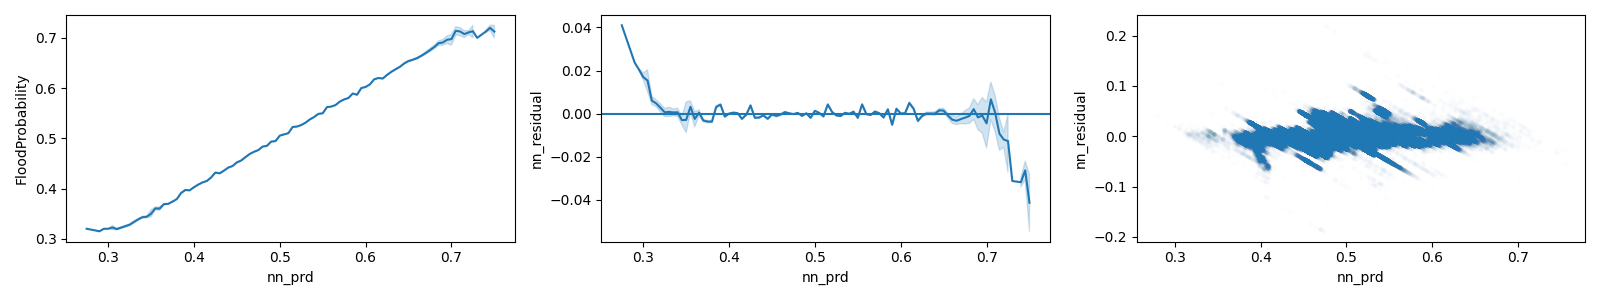

In [78]:
s_nn_prd = pd.Series(nn_prd, index=df_train.index, name='nn_prd')
s_nn_residual = (df_train[target] - s_nn_prd).rename('nn_residual')
cache_fig(
    'nn_diff_graph2', 
    partial(diff_graph, s_prd=s_nn_prd, s_res=s_nn_residual), 
    nrow=1, ncol=3, figsize=(16, 3)
)

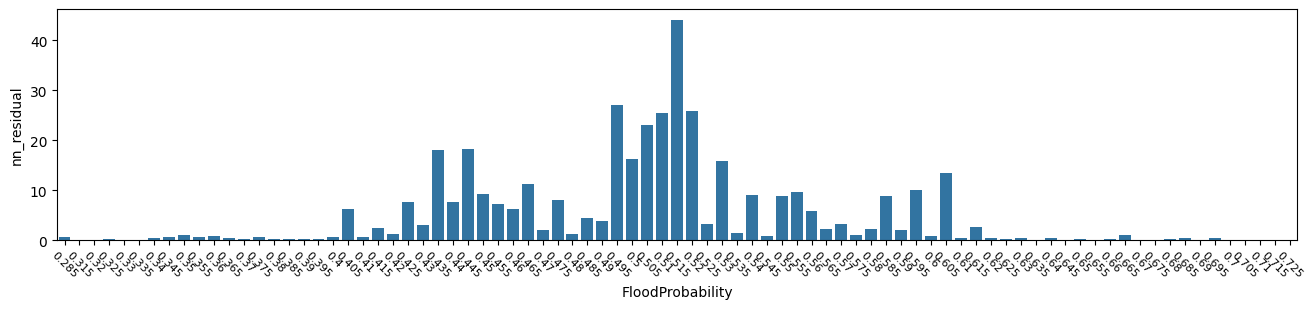

In [79]:
plt.figure(figsize=(16, 3))
sns.barplot((s_nn_residual ** 2).groupby(df_train[target]).sum())
plt.xticks(rotation=-45, fontsize=8)
plt.show()

Neural Network의 사이즈가 입력 데이터 수에 비해서 큰 편에 속합니다. 

NN 기반의 모델의 성능이 의문점이 들긴하지만 리소스를 투입해볼만하니 모델을 만들어 봅니다.

# FloodProbability와 s_values의 비율

In [103]:
df_train['ratio'] = df_train['FloodProbability'] / df_train['s_values']

In [112]:
s_prd_ratio = cache_result(
    'cv10_prd_lgb_ratio',
    lambda : cross_val_predict(lgb.LGBMRegressor(verbose=-1), df_train[X_sort + ['s_values', 's_values2']], df_train['ratio'], cv=cv10)
)

In [115]:
r2_score(df_train['ratio'], s_prd_ratio)

0.2066658123820806

In [114]:
s_cv_prd_lgb_ratio = (s_prd_ratio * df_train['s_values']).rename('cv_prd_lgb_ratio')
s_res_lgb_ratio = (df_train[target] - s_cv_prd_lgb_ratio).rename('s_res_lgb_ratio')
r2_score(df_train['FloodProbability'], s_cv_prd_lgb_ratio)

0.8689280913537789

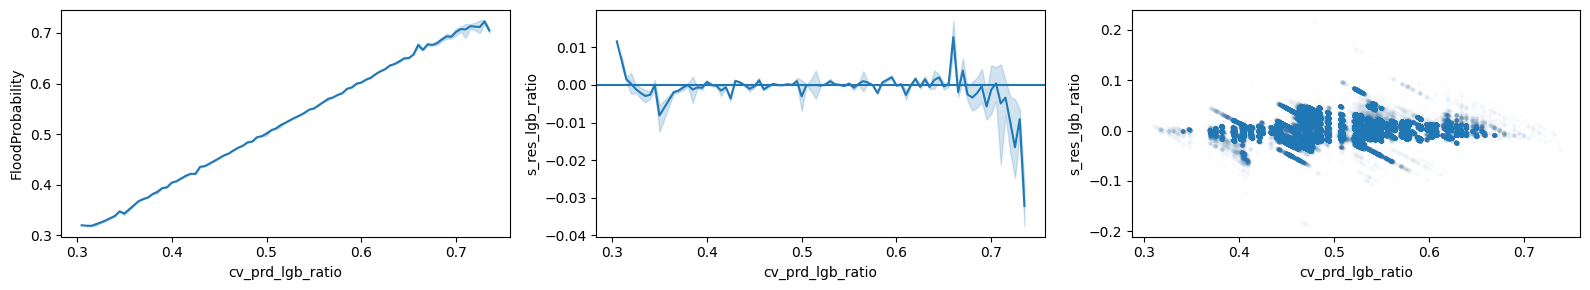

In [98]:
cache_fig(
    'nn_diff_lgb_ratio', 
    partial(diff_graph, s_prd=s_cv_prd_lgb_ratio, s_res=s_res_lgb_ratio), 
    nrow=1, ncol=3, figsize=(16, 3), redraw=True
)

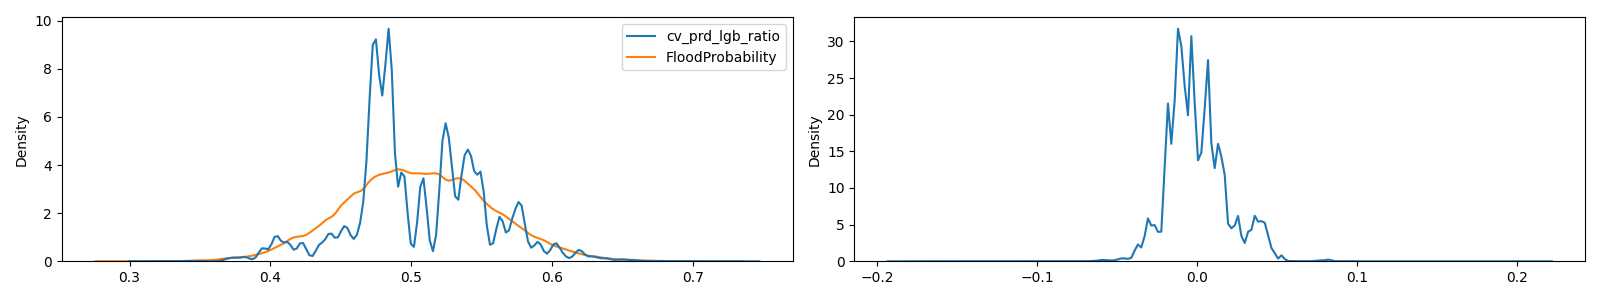

In [94]:
cache_fig(
    'kde_lgb_prd_ratio_residual',
    lambda x: kde_km_prd_target_residual(x, s_cv_prd_lgb_ratio, s_res_lgb_ratio), nrow=1, ncol=2, figsize=(16, 3)
)

# 의미 없어 보이는 내용

## Log1p 변환의 효과를 봅니다.

In [116]:
cv_prd = cache_result(
    'cv10_prd_linear_model_ln1p', 
    lambda : cross_val_predict(
        LinearRegression(), 
        pd.concat([
            df_train[X_all],
            (np.log(df_train[X_all].astype(np.float32) + 1)).rename(columns=lambda x: x + '_ln1p')
        ], axis=1), df_train[target], cv=cv10
    )
)
r2_score(df_train2[target], cv_prd)

0.8449913738054415

효과에 의구심이 듭니다.

## 합의 제곱근의 효과

예측값이 클 수록 음의 결과를 내고 있습니다. 제곱근의 효과가 있을지 살펴봅니다.

In [130]:
cv_prd = cache_result(
    'cv10_prd_linear_model_sqr', 
    lambda : cross_val_predict(
        LinearRegression(), 
        pd.concat([
            df_train[X_all],
            (df_train[X_all] ** 0.5).rename(columns=lambda x: x + '_2')
        ], axis=1), df_train[target], cv=KFold(n_splits=10, random_state=123, shuffle=True)
    )
)
r2_score(df_train2[target], cv_prd)

0.8450012333928638

역시, 효과에 의구심이 듭니다.

# Train/Test/Org의 차이를 살펴 봅니다.

In [26]:
from sklearn.model_selection import cross_val_score

def check_diff_train_test():
    df_check = pd.concat([
        df_train[X_all].assign(
            is_train=True
        ),
        df_test[X_all].assign(
            is_train=False
        )
    ], axis=0)
    clf_check = lgb.LGBMClassifier(verbose=-1)
    return cross_val_score(clf_check, df_check[X_all], df_check['is_train'], scoring='roc_auc', cv=5)
result = cache_result('train_test_diff', check_diff_train_test)
np.mean(result)

0.5001223468794278

In [29]:
def check_diff_train_org():
    df_check = pd.concat([
        df_train[X_all].assign(
            is_train=True
        ),
        df_org[X_all].assign(
            is_train=False
        )
    ], axis=0)
    clf_check = lgb.LGBMClassifier(verbose=-1)
    return cross_val_score(clf_check, df_check[X_all], df_check['is_train'], scoring='roc_auc', cv=5)
result = cache_result('train_org_diff', check_diff_train_org)
np.mean(result)

0.6338711250998713

In [30]:
def check_diff_test_org():
    df_check = pd.concat([
        df_test[X_all].assign(
            is_test=True
        ),
        df_org[X_all].assign(
            is_test=False
        )
    ], axis=0)
    clf_check = lgb.LGBMClassifier(verbose=-1)
    return cross_val_score(clf_check, df_check[X_all], df_check['is_test'], scoring='roc_auc', cv=5)
result = cache_result('test_org_diff', check_diff_test_org)
np.mean(result)

0.6340276171500259

Train과 Test는 구분할 수있는 포인트가 없어 보입니다

Org는 Train, Test와 약간의 차이를 보이고 있습니다.